In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt

# Project imports
import pyhalomodel.pyhalomodel as halo
import pyhalomodel.camb_stuff as camb_stuff

Mean matter density [log10((Msun/h)/(Mpc/h)^-3)]: 10.981144712491556
Mass tracer: True
Discrete tracer: False
Field normalisation: 95751307378.11139
Number of wavenumber bins: 101
Number of mass bins: 256
Wavenumber range [log10(h/Mpc)]: -3.000 1.000
Halo mass range [log10(Msun/h)]: 9.000 17.000
The following are at the low and high halo mass ends
Profile amplitude mean [log10]: 9.0 17.0
Dimensionless profiles at low k (should be ~1): 0.9999999999859064 0.9999954830084209
Dimensionful profiles at low k (should be amplitudes): 0.010443721630212486 1044367.4456157018

Mean galaxy density [(Mpc/h)^-3]: 0.004925937715236814


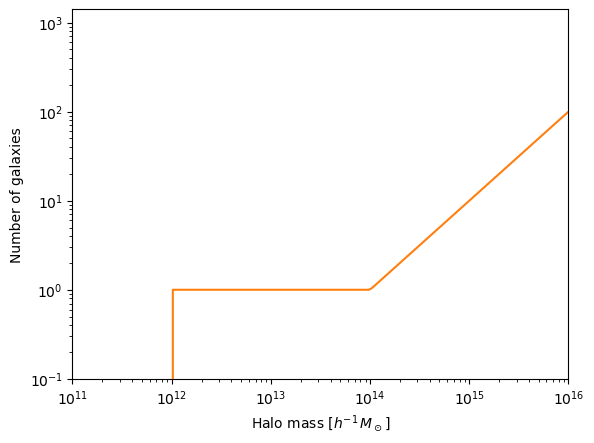

Mass tracer: False
Discrete tracer: True
Field normalisation: 0.004925937715236814
Number of wavenumber bins: 101
Number of mass bins: 256
Wavenumber range [log10(h/Mpc)]: -3.000 1.000
Halo mass range [log10(Msun/h)]: 9.000 17.000
The following are at the low and high halo mass ends
Profile amplitude mean: 0.0 1000.0
Dimensionless profiles at low k (should be ~1): 0.9999999999859064 0.9999954830084209
Dimensionful profiles at low k (should be amplitudes): 0.0 203006.11595539554



In [4]:
# Set cosmological parameters
Omega_c = 0.3
Omega_b = 0.045
Omega_k = 0.0
h = 0.7
As = 1.97448e-9
ns = 0.96
w = -1.0
wa = 0.0
m_nu = 0.0 # in eV
sigma_8_set = True # if true uses the following value
sigma_8  = 0.9

# Colours
col_lin = 'black'
col_mat = 'C0'
col_gal = 'C1'
col_mg  = 'C4'

# Line styles
ls_li = '-'
ls_hm = '-'
ls_2h = '--'
ls_1h = ':'

# Labels
klab = r'$k\,/\,h \mathrm{Mpc}^{-1}$'

# k range [h/Mpc]
kmin = 1e-3; kmax = 10.
nk = 101
ks = np.logspace(np.log10(kmin), np.log10(kmax), nk)

# Redshift
z = 0

# CAMB
Pk_lin, camb_results, Omega_m, _, _ = camb_stuff.run(np.array([z]), Omega_c, Omega_b, Omega_k, h, ns, sigma_8)
Pks_lin = Pk_lin(z, ks)

# Initialise halo model
hmod = halo.model(z, Omega_m, name='Tinker et al. (2010)', Dv=330.)

# Calculate the matter density
print('Mean matter density [log10((Msun/h)/(Mpc/h)^-3)]:', np.log10(hmod.rhom))

# Mass range
Mmin, Mmax = 1e9, 1e17
nM = 256
Ms = np.logspace(np.log10(Mmin), np.log10(Mmax), nM)

# Lagrangian radii corresponding to halo masses; 
Rs = hmod.Lagrangian_radius(Ms)

# Get sigma(R) from CAMB
sigmaRs = camb_results.get_sigmaR(Rs, hubble_units=True, return_R_z=False)[[z].index(z)]

# Initialise profile class
rvs = hmod.virial_radius(Ms)
cs = halo.concentration(Ms, z, method='Duffy et al. (2008)', halo_definition='Mvir')
matter_profile = halo.matter_profile(ks, Ms, rvs, cs, hmod.Om_m)
print(matter_profile)

# Simple (unrealistic) HOD model
def HOD(M, Mmin=1e12, Msat=1e14):
    if M < Mmin:
        return 0.
    elif Mmin <= M and M < Msat:
        return 1.
    else:
        #return np.rint(M/Msat)
        return M/Msat
HOD = np.vectorize(HOD)
 
# Compute the mean galaxy density corresponding to our HOD
Ng = HOD(Ms)
rhog = hmod.average(Ms, sigmaRs, Ng)
print('Mean galaxy density [(Mpc/h)^-3]:', rhog)

# Plot HOD
plt.loglog(Ms, Ng, color=col_gal)
plt.xlabel('Halo mass [$h^{-1}\,M_\odot$]')
plt.ylabel('Number of galaxies')
plt.ylim(bottom=1e-1)
plt.xlim((1e11, 1e16))
plt.show()

# Galaxy profile
Uk = halo.window_function(ks, rvs, cs, profile='NFW')
galaxy_profile = halo.profile.Fourier(ks, Ms, Uk, amplitude=Ng, normalisation=rhog, discrete_tracer=True)
print(galaxy_profile)

# Calculate the halo-model power spectrum
profiles = {'m': matter_profile, 'g': galaxy_profile}
Pk_2h, Pk_1h, Pk_hm = hmod.power_spectrum(ks, Pks_lin, Ms, sigmaRs, profiles)

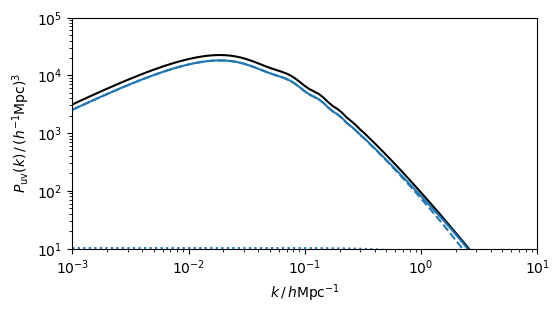

In [5]:
# Initialise plot
plt.subplots(1, 1, figsize=(6., 3.))
Pkmin, Pkmax = 1e1, 1e5
kmin_plot, kmax_plot = 1e-3, 1e3
rmin, rmax = 1e-1, 3e2
smin, smax = 0., 5.5

# Lists for plots
Pks = [Pk_2h['g-g'], Pk_1h['g-g'], Pk_hm['g-g'],]
cols = 3*[col_mat]+[col_gal, col_mg]
lss = [ls_2h, ls_1h, ls_hm, ls_hm, ls_hm]
labs = [None, None, 'Galaxy',]

# P(k)
plt.loglog(ks, Pks_lin, color=col_lin, label='Linear')
for (ls, lab) in zip([ls_2h, ls_1h], ['Two-halo term', 'One-halo term']):
    plt.plot(np.nan, ls=ls, label=lab, color='black')
for (Pk, col, ls, lab) in zip(Pks, cols, lss, labs):
    plt.loglog(ks, Pk, color=col, ls=ls, label=lab)
plt.ylim((1e1,1e5))
plt.xlim((1e-3,1e1))
plt.ylabel(r'$P_{\rm uv}(k)\,/\,(h^{-1} \mathrm{Mpc})^3$')
plt.xlabel(klab)

#plt.legend(ncol=2, loc='lower left', fontsize='9')

# Finish
plt.show()